In [1]:
import itertools
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns

from env import get_db_url

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 250)


In [3]:
# Pull down curriculum logs data from SQL server
url = get_db_url('curriculum_logs')
query = 'SELECT * FROM logs'

df = pd.read_sql(query, url)

# Check data
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900223 entries, 0 to 900222
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   date       900223 non-null  object 
 1   time       900223 non-null  object 
 2   path       900222 non-null  object 
 3   user_id    900223 non-null  int64  
 4   cohort_id  847330 non-null  float64
 5   ip         900223 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 41.2+ MB


In [6]:
# Copy curriculum logs data to CSV (because it's kind of a big dataset)
df.to_csv('curriculum_logs.csv')

# Make function query for acquire.py module
import os

def get_curriculum_logs():
    filename = 'curriculum_logs.csv'
    if os.path.exists(filename):
        print('Reading from CSV...')
        return pd.read_csv(filename)

    query = 'SELECT * FROM logs'
    print('Getting a fresh copy from SQL db...')
    url = get_db_url('curriculum_logs')
    df = pd.read_sql(query, url)
    print('Copying to CSV...')
    df.to_csv(filename)
    return df


In [7]:
# Check head of data
df.head()

,date,time,path,user_id,cohort_id,ip
0,2018-01-26,09:55:03,/,1,8.0,97.105.19.61
1,2018-01-26,09:56:02,java-ii,1,8.0,97.105.19.61
2,2018-01-26,09:56:05,java-ii/object-oriented-programming,1,8.0,97.105.19.61
3,2018-01-26,09:56:06,slides/object_oriented_programming,1,8.0,97.105.19.61
4,2018-01-26,09:56:24,javascript-i/conditionals,2,22.0,97.105.19.61


In [2]:

def get_grocery_customers():
    filename = 'grocery_customers.csv'
    if os.path.exists(filename):
        print('Reading from CSV...')
        return pd.read_csv(filename)

    query = 'SELECT * FROM grocery_customers'
    print('Getting a fresh copy from SQL db...')
    url = get_db_url('grocery_db')
    df = pd.read_sql(query, url)
    print('Copying to CSV...')
    df.to_csv(filename, index=False)
    return df


grocery_df = get_grocery_customers()

Reading from CSV...


In [3]:
grocery_df.info()
grocery_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Unnamed: 0        440 non-null    int64
 1   customer_id       440 non-null    int64
 2   Channel           440 non-null    int64
 3   Region            440 non-null    int64
 4   Fresh             440 non-null    int64
 5   Milk              440 non-null    int64
 6   Grocery           440 non-null    int64
 7   Frozen            440 non-null    int64
 8   Detergents_Paper  440 non-null    int64
 9   Delicassen        440 non-null    int64
dtypes: int64(10)
memory usage: 34.5 KB


,Unnamed: 0,customer_id,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,0,0,2,3,12669,9656,7561,214,2674,1338
1,1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,3,1,3,13265,1196,4221,6404,507,1788
4,4,4,2,3,22615,5410,7198,3915,1777,5185


In [4]:
grocery_df.columns = [col.lower() for col in grocery_df.columns]

grocery_df.columns

Index(['unnamed: 0', 'customer_id', 'channel', 'region', 'fresh', 'milk',
       'grocery', 'frozen', 'detergents_paper', 'delicassen'],
      dtype='object')

In [5]:
grocery_df.info()
grocery_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   unnamed: 0        440 non-null    int64
 1   customer_id       440 non-null    int64
 2   channel           440 non-null    int64
 3   region            440 non-null    int64
 4   fresh             440 non-null    int64
 5   milk              440 non-null    int64
 6   grocery           440 non-null    int64
 7   frozen            440 non-null    int64
 8   detergents_paper  440 non-null    int64
 9   delicassen        440 non-null    int64
dtypes: int64(10)
memory usage: 34.5 KB


,unnamed: 0,customer_id,channel,region,fresh,milk,grocery,frozen,detergents_paper,delicassen
0,0,0,2,3,12669,9656,7561,214,2674,1338
1,1,1,2,3,7057,9810,9568,1762,3293,1776
2,2,2,2,3,6353,8808,7684,2405,3516,7844
3,3,3,1,3,13265,1196,4221,6404,507,1788
4,4,4,2,3,22615,5410,7198,3915,1777,5185


In [6]:
# Rename misspelled delicatessen column ("What is this delikhassen? Do they serve halal meats at this delikhassen?")
grocery_df = grocery_df.rename(columns= {'delicassen': 'deli'})
# Check column names
grocery_df.columns


Index(['unnamed: 0', 'customer_id', 'channel', 'region', 'fresh', 'milk',
       'grocery', 'frozen', 'detergents_paper', 'deli'],
      dtype='object')

In [7]:
print(f'Grocery channel:\n{grocery_df.channel.value_counts()}')
print('------------')
print(f'Grocery regions:\n{grocery_df.region.value_counts().sort_index()}')

Grocery channel:
1    298
2    142
Name: channel, dtype: int64
------------
Grocery regions:
1     77
2     47
3    316
Name: region, dtype: int64


In [8]:
# Final cleaning: drop customer_id column, cast channel and region columns as dtype 'object'
grocery_df = grocery_df.drop(columns= ['unnamed: 0', 'customer_id'])
grocery_df.channel = grocery_df.channel.astype('object')
grocery_df.region = grocery_df.region.astype('object')

grocery_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   channel           440 non-null    object
 1   region            440 non-null    object
 2   fresh             440 non-null    int64 
 3   milk              440 non-null    int64 
 4   grocery           440 non-null    int64 
 5   frozen            440 non-null    int64 
 6   detergents_paper  440 non-null    int64 
 7   deli              440 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 27.6+ KB


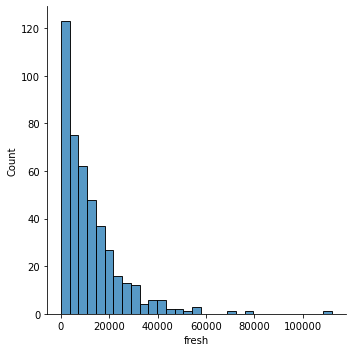

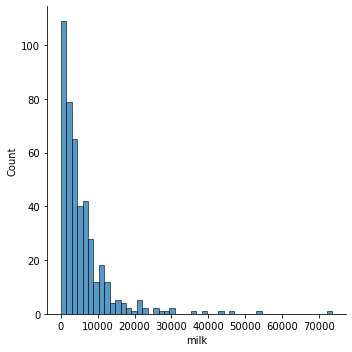

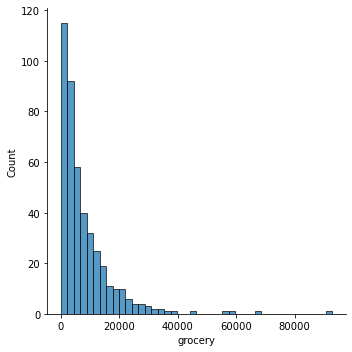

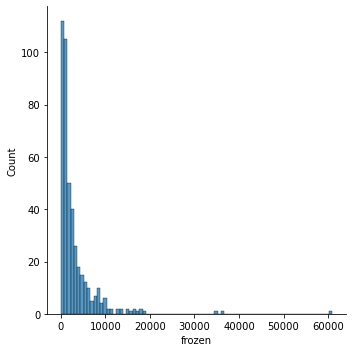

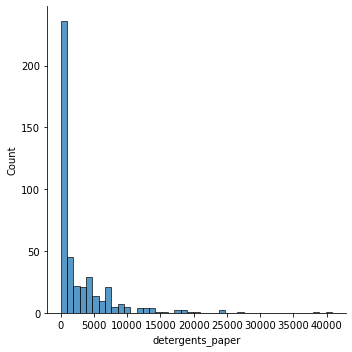

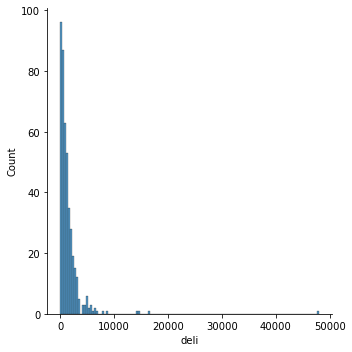

In [9]:
# Viz distributions
for col in grocery_df.select_dtypes(np.int64).columns:
    sns.displot(data=grocery_df, x=grocery_df[col])
    plt.show()

In [10]:
# View summary stats
grocery_df.describe()

,fresh,milk,grocery,frozen,detergents_paper,deli
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [11]:
#Split and scale grocery data

from prep import get_splits, minmax_scale_data

g_train, g_validate, g_test = get_splits(grocery_df)

print(g_train.shape, g_validate.shape, g_test.shape)

g_train_scaled, g_validate_scaled, g_test_scaled = minmax_scale_data(g_train, g_validate, g_test, g_train.select_dtypes(include=np.int64).columns)

g_train_scaled.head()


(246, 8) (106, 8) (88, 8)


,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli
271,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918
309,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498
269,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892
43,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769
401,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246


In [12]:
# Make cluster object and fit it to scaled data
dbsc = DBSCAN(eps= .10, min_samples=20)
dbsc.fit(g_train_scaled)

DBSCAN(eps=0.1, min_samples=20)

In [13]:
g_train_scaled['labels'] = dbsc.labels_

g_train_scaled.labels.value_counts()

-1    168
 0     78
Name: labels, dtype: int64

In [14]:
g_train_scaled.columns = ['scaled_' + col for col in g_train_scaled.columns]

g_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 271 to 419
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   scaled_channel           246 non-null    object 
 1   scaled_region            246 non-null    object 
 2   scaled_fresh             246 non-null    float64
 3   scaled_milk              246 non-null    float64
 4   scaled_grocery           246 non-null    float64
 5   scaled_frozen            246 non-null    float64
 6   scaled_detergents_paper  246 non-null    float64
 7   scaled_deli              246 non-null    float64
 8   scaled_labels            246 non-null    int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 19.2+ KB


In [15]:
g_train = pd.concat([g_train, g_train_scaled], axis=1, ignore_index=False)

g_train.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_channel,scaled_region,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels
271,1,1,2083,5007,1563,1120,147,1550,1,1,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1
309,2,2,918,20655,13567,1465,6846,806,2,2,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1
269,1,1,15218,258,1138,2516,333,204,1,1,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1
43,2,3,630,11095,23998,787,9529,72,2,3,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1
401,1,3,27167,2801,2128,13223,92,1902,1,3,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1


In [16]:
g_train = g_train.drop(columns= ['scaled_channel', 'scaled_region'])

g_train.head()

,channel,region,fresh,milk,grocery,frozen,detergents_paper,deli,scaled_fresh,scaled_milk,scaled_grocery,scaled_frozen,scaled_detergents_paper,scaled_deli,scaled_labels
271,1,1,2083,5007,1563,1120,147,1550,0.027284,0.129248,0.023182,0.017787,0.003780,0.106918,-1
309,2,2,918,20655,13567,1465,6846,806,0.012003,0.537662,0.201560,0.023458,0.179611,0.055498,-1
269,1,1,15218,258,1138,2516,333,204,0.199583,0.005298,0.016866,0.040736,0.008662,0.013892,-1
43,2,3,630,11095,23998,787,9529,72,0.008225,0.288145,0.356564,0.012313,0.250033,0.004769,-1
401,1,3,27167,2801,2128,13223,92,1902,0.356324,0.071671,0.031577,0.216748,0.002336,0.131246,-1
